<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/adding_C4/C4/W1/ungraded_labs/C4_W1_Lab_1_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [157]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In the screencast for this lesson I go through a few scenarios for time series. This notebook contains the code for that with a few little extras! :)

**Note:** This notebook can run using TensorFlow 2.5.0

In [158]:
#!pip install tensorflow==2.5.0

In [159]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [160]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

# Trend and Seasonality

In [161]:
def trend(time, slope=0):
    return slope * time

Let's create a time series that just trends upward:

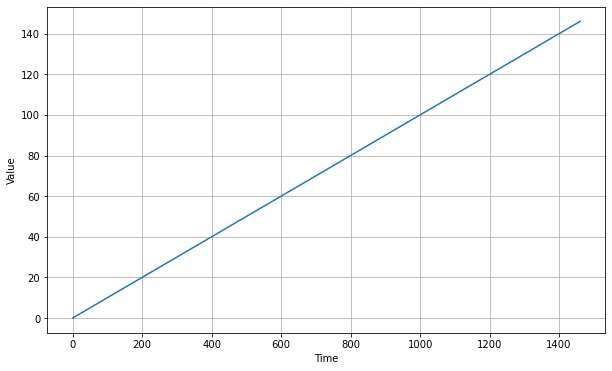

In [162]:
time = np.arange(4 * 365 + 1)
baseline = 10
series = trend(time, 0.1)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

Now let's generate a time series with a seasonal pattern:

In [163]:
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

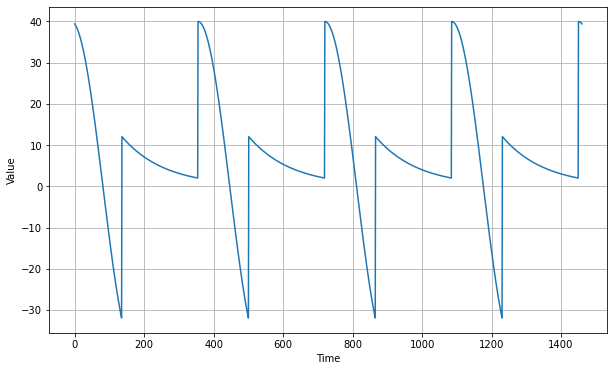

In [164]:
baseline = 10
amplitude = 40
series = seasonality(time, phase=10, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

Now let's create a time series with both trend and seasonality:

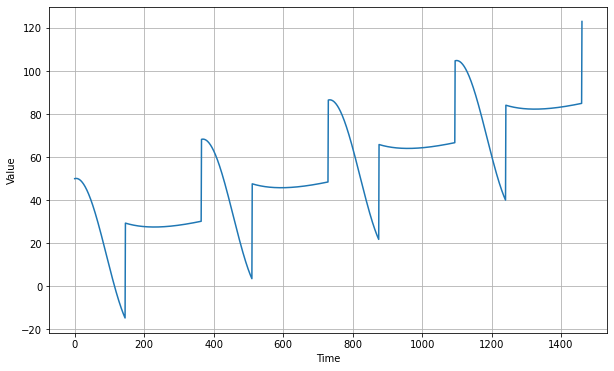

In [165]:
slope = 0.05
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

# Noise

In practice few real-life time series have such a smooth signal. They usually have some noise, and the signal-to-noise ratio can sometimes be very low. Let's generate some white noise:

In [166]:
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

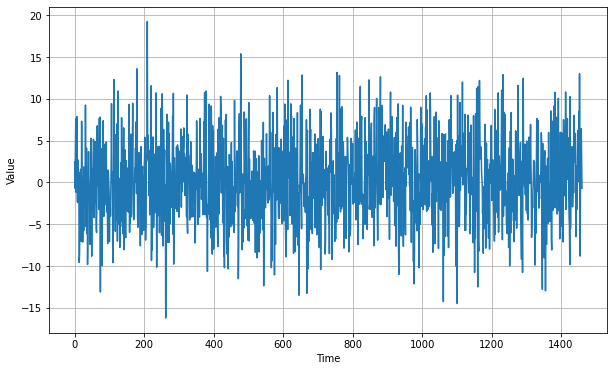

In [167]:
noise_level = 5
noise = white_noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, noise)
plt.show()

Now let's add this white noise to the time series:

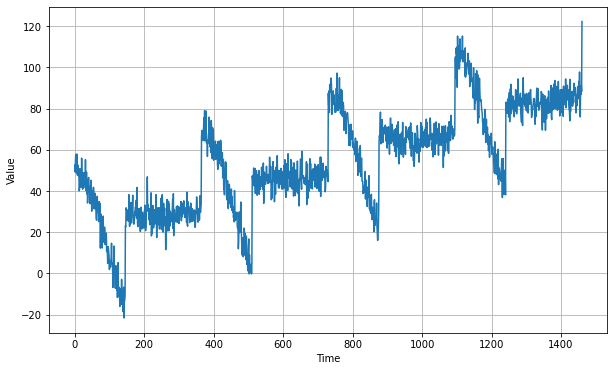

In [168]:
series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

All right, this looks realistic enough for now. Let's try to forecast it. We will split it into two periods: the training period and the validation period (in many cases, you would also want to have a test period). The split will be at time step 1000.

In [169]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [170]:
def autocorrelation(time, amplitude, seed=None):
    rnd = np.random.RandomState(seed)
    φ1 = 0.5
    φ2 = -0.1
    ar = rnd.randn(len(time) + 50)
    ar[:50] = 100
    for step in range(50, len(time) + 50):
        ar[step] += φ1 * ar[step - 50]
        ar[step] += φ2 * ar[step - 33]
    return ar[50:] * amplitude

In [171]:
def autocorrelation(time, amplitude, seed=None):
    rnd = np.random.RandomState(seed)
    φ = 0.8
    ar = rnd.randn(len(time) + 1)
    for step in range(1, len(time) + 1):
        ar[step] += φ * ar[step - 1]
    return ar[1:] * amplitude

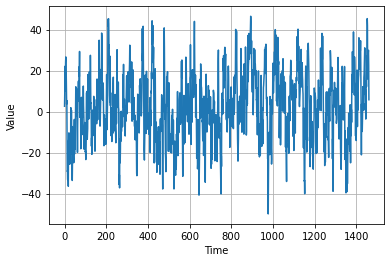

In [172]:
series = autocorrelation(time, 10, seed=42)
plot_series(time, series)
plt.show()

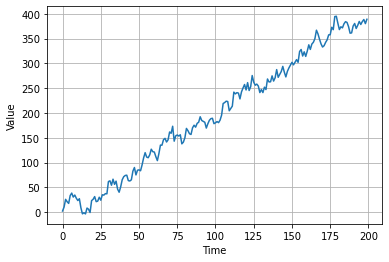

In [173]:
series = autocorrelation(time, 10, seed=42) + trend(time, 2)
plot_series(time[:200], series[:200])
plt.show()

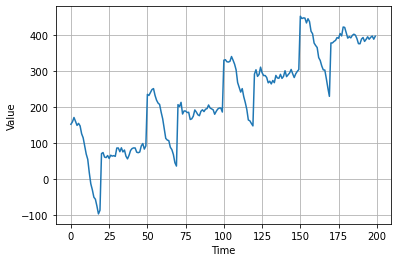

In [174]:
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
plot_series(time[:200], series[:200])
plt.show()

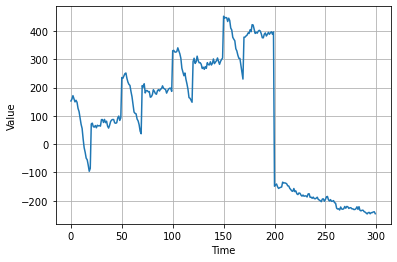

In [175]:
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
series2 = autocorrelation(time, 5, seed=42) + seasonality(time, period=50, amplitude=2) + trend(time, -1) + 50
series[200:] = series2[200:]
#series += noise(time, 30)
plot_series(time[:300], series[:300])
plt.show()

In [176]:
def impulses(time, num_impulses, amplitude=1, seed=None):
    rnd = np.random.RandomState(seed)
    impulse_indices = rnd.randint(len(time), size=10)
    series = np.zeros(len(time))
    for index in impulse_indices:
        series[index] += rnd.rand() * amplitude
    return series    

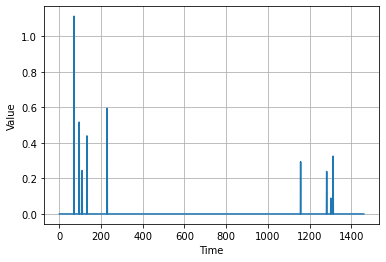

In [177]:
series = impulses(time, 10, seed=50)
plot_series(time, series)
plt.show()

In [178]:
def autocorrelation(source, φs):
    ar = source.copy()
    max_lag = len(φs)
    for step, value in enumerate(source):
        for lag, φ in φs.items():
            if step - lag > 0:
              ar[step] += φ * ar[step - lag]
    return ar

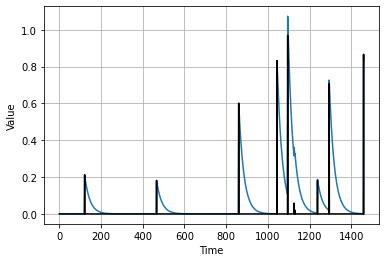

In [179]:
signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {1: 0.96})
plot_series(time, series)
plt.plot(time, signal, "k-")
plt.show()

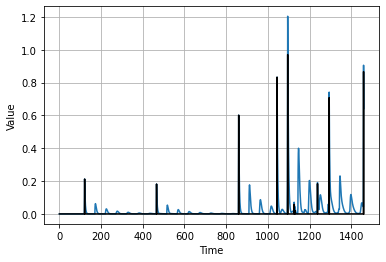

In [180]:
signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {1: 0.70, 50: 0.2})
plot_series(time, series)
plt.plot(time, signal, "k-")
plt.show()

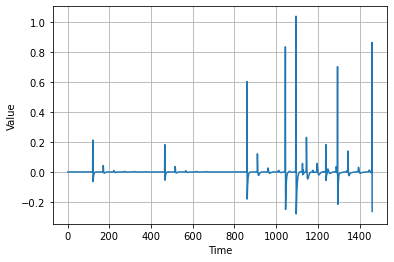

In [181]:
series_diff1 = series[1:] - series[:-1]
plot_series(time[1:], series_diff1)

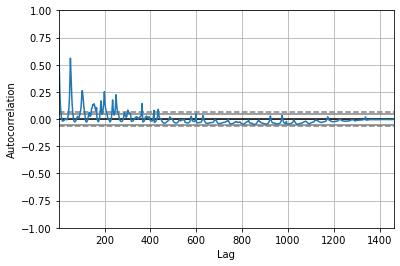

In [182]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(series)

In [183]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1461
Model:                 ARIMA(5, 1, 0)   Log Likelihood                2223.354
Date:                Thu, 07 Apr 2022   AIC                          -4434.708
Time:                        15:22:43   BIC                          -4402.991
Sample:                             0   HQIC                         -4422.876
                               - 1461                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1235      0.009    -13.155      0.000      -0.142      -0.105
ar.L2         -0.1256      0.016     -7.759      0.000      -0.157      -0.094
ar.L3         -0.1091      0.018     -6.160      0.0

In [184]:
# Sunspots.csv
!gdown --id 1bLnqPgwoSh6rHz_DKDdDeQyAyl8_nqT5

C:\Users\devas\AppData\Local\pypoetry\Cache\virtualenvs\tensorflow-1-public-cSeBuBzT-py3.7\lib\site-packages\gdown\cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1bLnqPgwoSh6rHz_DKDdDeQyAyl8_nqT5
To: D:\Source\Sandoxes\tensorflow-1-public\C4\W1\ungraded_labs\Sunspots.csv

  0%|          | 0.00/70.8k [00:00<?, ?B/s]
100%|##########| 70.8k/70.8k [00:00<00:00, 35.3MB/s]


In [185]:
import pandas as pd

df = pd.read_csv('./Sunspots.csv', parse_dates=["Date"], index_col="Date")
series = df["Monthly Mean Total Sunspot Number"].asfreq("1M")
series.head()

Date
1749-01-31     96.7
1749-02-28    104.3
1749-03-31    116.7
1749-04-30     92.8
1749-05-31    141.7
Freq: M, Name: Monthly Mean Total Sunspot Number, dtype: float64

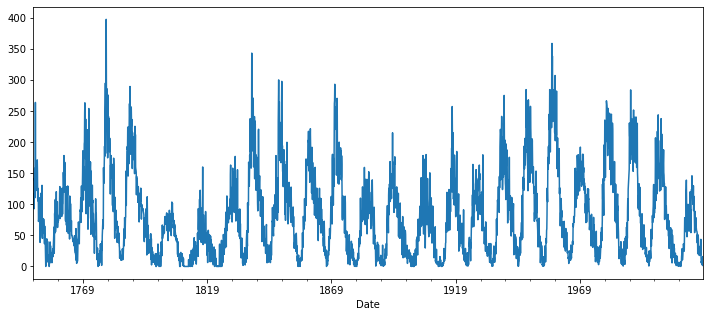

In [186]:
series.plot(figsize=(12, 5))

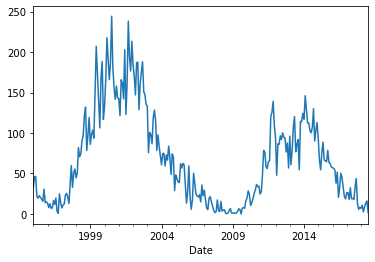

In [187]:
series["1995-01-01":].plot()

(0.0, 100.0, -50.0, 50.0)

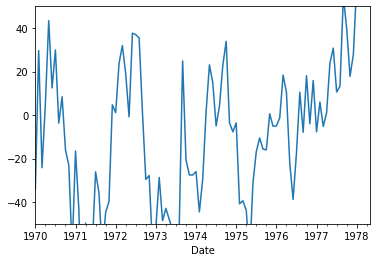

In [188]:
series.diff(10).plot()
plt.axis([0, 100, -50, 50])

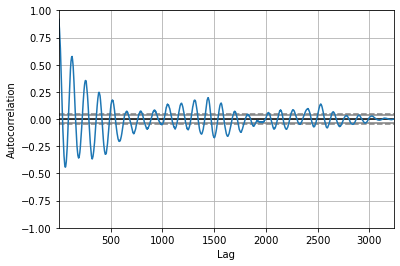

In [189]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(series)

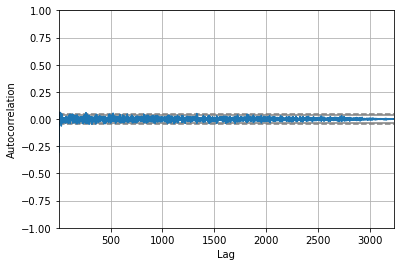

In [190]:
autocorrelation_plot(series.diff(1)[1:])

(0.0, 500.0, -0.1, 0.1)

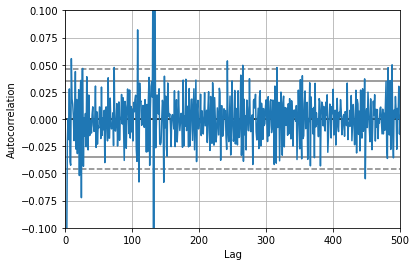

In [191]:
autocorrelation_plot(series.diff(1)[1:].diff(11 * 12)[11*12+1:])
plt.axis([0, 500, -0.1, 0.1])

(0.0, 50.0, -0.1, 0.1)

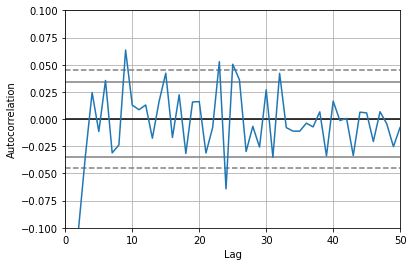

In [192]:
autocorrelation_plot(series.diff(1)[1:])
plt.axis([0, 50, -0.1, 0.1])

In [193]:
116.7 - 104.3

12.400000000000006

In [194]:
[series.autocorr(lag) for lag in range(1, 50)]

[0.9173241872367172,
 0.8847544206843758,
 0.8685991231372021,
 0.8579945644357171,
 0.8433856340533111,
 0.8306731729540907,
 0.8121138897370149,
 0.7986059878541056,
 0.7890399489112039,
 0.7689560950230409,
 0.7474788716472306,
 0.7238791854325144,
 0.6980482665379879,
 0.6751408790165825,
 0.6495670049994805,
 0.6170092179855496,
 0.5872028494447984,
 0.5537209387574675,
 0.5254318210710769,
 0.49453915657274083,
 0.46092250015237807,
 0.4325062022560218,
 0.40543298836102487,
 0.3695928959353227,
 0.3443549899460771,
 0.31069676226343473,
 0.2711411693399097,
 0.23646964014948232,
 0.20297806535027263,
 0.17379537689762678,
 0.14010793836897958,
 0.11227445177460692,
 0.07751076852866033,
 0.044054957960606746,
 0.012510863120931952,
 -0.017282156504566323,
 -0.046433352357512246,
 -0.07440203532677167,
 -0.10339501296715738,
 -0.12680806162977243,
 -0.1530928264197593,
 -0.17906178224521466,
 -0.20506772757843425,
 -0.22530867957591916,
 -0.2466587000579558,
 -0.26904607854968615

In [195]:
#Read a comma-separated values (csv) file into DataFrame.
pd.read_csv('./Sunspots.csv', sep=',', delimiter=None, header='infer', names=None, 
            index_col=None, usecols=None, squeeze=False, prefix=None, mangle_dupe_cols=True, 
            dtype=None, engine=None, converters=None, true_values=None, false_values=None, 
            skipinitialspace=False, skiprows=None, skipfooter=0, nrows=None, na_values=None, 
            keep_default_na=True, na_filter=True, verbose=False, skip_blank_lines=True, parse_dates=False, 
            infer_datetime_format=False, keep_date_col=False, date_parser=None, dayfirst=False, iterator=False, 
            chunksize=None, compression='infer', thousands=None, decimal=b'.', lineterminator=None, quotechar='"', 
            quoting=0, doublequote=True, escapechar=None, comment=None, encoding=None, dialect=None, 
            error_bad_lines=True, warn_bad_lines=True, delim_whitespace=False, 
            low_memory=True, memory_map=False, float_precision=None)

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7
...,...,...,...
3230,3230,2018-03-31,2.5
3231,3231,2018-04-30,8.9
3232,3232,2018-05-31,13.2
3233,3233,2018-06-30,15.9


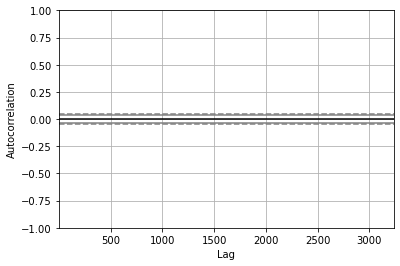

In [196]:
from pandas.plotting import autocorrelation_plot

series_diff = series
for lag in range(50):
  series_diff = series_diff[1:] - series_diff[:-1]

autocorrelation_plot(series_diff)

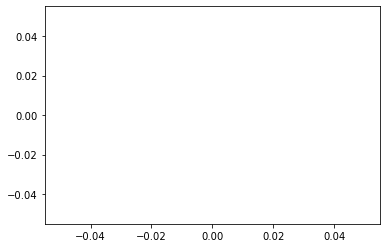

In [197]:
series_diff1 = pd.Series(series[1:] - series[:-1])
autocorrs = [series_diff1.autocorr(lag) for lag in range(1, 60)]
plt.plot(autocorrs)
plt.show()